# The Battle of Dallas Neighborhoods：
# Explore the School District in Dallas-Fort Worth-Arlington metroplex

## Introduction: Business Problem


Texas has become one of the hottest states for relocation. According to the 2021 edition of the Texas Relocation Report released by Texas Realtors, Texas welcomed 537,000 – 582,000 new residents in 2019. On the metropolitan statistical area (MSA) level, the Dallas-Fort Worth-Arlington MSA and Houston-The Woodlands-Sugar Land MSA recorded the highest number of incoming residents from out-of-state. According to the analysis reported by Redfin, Dallas become the metro area with the second biggest net inflow in 2020, with a net flow of 75,000. Reason for relocating to Texas includes the availability of job, low cost of living, and affordable housing. Since an increasing number of tech companies moving into Texas will bring more job opportunities, the trend of net inflow into Texas will keep growing. 

For people who are planning to relocate into a new city, choosing the right neighborhood for living can be a big task, as living in the right neighborhood would help people get familiar with the new environment quickly and improve one’s living quality in long term. There are many concerns for choosing the neighborhood, including location, safety, housing cost, infrastructure, traffic, etc. For those having children, the education resource is also an important concern. Therefore, we believe that visualizing the geographical distance to the school district, and an easy access to the school information within certain neighborhood will be helpful to decide the right neighborhood to live in. 

The problem that we focus in this project is that, what is the optimum neighborhood for someone who have the concern of schooling to relocate to cities like Dallas? Therefore, in this project, we would like to explore the educational resources illustrated by map and explore the optimal neighborhood for relocation for someone who is planning to move to cities in Texas. Specifically, this report will be targeted to stakeholders interested in finding the neighborhoods based on school district with good performances and average rate. 

In this project, we are going to explore the neighborhoods based on three aspects: accessibility to school based on geospatial location, housing expense, and venues. Based on definition of our problem, factors that will influence our decision  are:
* **School performance**: number of school in the neighborhood, the grade, and the performances
* **Housing expense**: Medium house value
* **Convinence for living**: determined by the number of venue categories within the neighborhood
We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## 1. Data acquisition and cleaning



Following data sources will be needed to extract/generate the required information:
* Schools information in Texas are extracted from the **Texas Education Agency Open Data Website**, including the name of school, coordinates, scores, and grades that the school provides
* The number of venues and their type and location in every neighborhood will be obtained using **Foursquare API**


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Download the csv data from Texas Education Agency

In [3]:
df=pd.read_csv('Current_Schools.csv')

C:\Users\maggi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (45,66,67,102) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.shape

(9498, 116)

In [5]:
#create dataframe school that only contains information relevant to the study
school=df[['School_Nam','Score','Match_addr','City','MetroArea','Subregion','X','Y','Grade_Leve']]

In [6]:

# Create the dictionary 
Grade_dictionary ={'Elementary' :0, 'Elementary/Secondary' : 1, 'Middle' : 2, 'Junior High' : 3,'High School':4} 
  
# Add a new column named 'Price' 
school['Grade_Number'] = df['Grade_Leve'].map(Grade_dictionary) 
  
# Print the DataFrame 
school.dropna(inplace=True)
#school.shape
school.groupby('Grade_Leve')['Grade_Leve'].count()

<ipython-input-6-55ce666fac61>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school['Grade_Number'] = df['Grade_Leve'].map(Grade_dictionary)
<ipython-input-6-55ce666fac61>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school.dropna(inplace=True)


Grade_Leve
Elementary              4892
Elementary/Secondary    1206
High School             1597
Junior High              225
Middle                  1480
Name: Grade_Leve, dtype: int64

In [7]:
school.head()
#school.groupby('Grade_Leve').count()

,School_Nam,Score,Match_addr,City,MetroArea,Subregion,X,Y,Grade_Leve,Grade_Number
0,CAYUGA H S,100.0,"17750 N US Highway 287, Tennessee Colony, Texa...",Tennessee Colony,,Anderson County,-95.924741,31.922265,High School,4.0
1,CAYUGA MIDDLE,100.0,0,Tennessee Colony,,Anderson County,-95.924741,31.922265,Middle,2.0
2,CAYUGA EL,100.0,"17750 N US Highway 287, Tennessee Colony, Texa...",Tennessee Colony,,Anderson County,-95.924741,31.922265,Elementary,0.0
3,ELKHART DAEP,100.0,"420 W Palestine Ave, Palestine, Texas, 75801",Palestine,,Anderson County,-95.638329,31.769995,Elementary/Secondary,1.0
4,NECHES H S,100.0,"1509 ACR 346, Palestine, Texas, 75803",Palestine,,Anderson County,-95.476226,31.871807,High School,4.0


In [8]:
#Filter school that locates in Houston, Dallas and Austin
Houston=school.loc[school['Subregion']=='Harris County']
Dallas=school.loc[(school['Subregion']=='Dallas County') | (school['Subregion']=='Tarrant County')]
Austin=school.loc[(school['Subregion']=='Travis County')]

In [89]:
#total number of school in Dallas
Dallas.shape

(1342, 10)

## 2. Visualize school location, name and grade in map

After filtering the schools that locates in Dallas, we cluster and put schools in maps, and classify them into different colors based on the grade. 

In [10]:
from folium import plugins

In [13]:
#total number of school in Dallas
Dallas.shape

(1342, 10)

### Compare the school number and performance in Dallas-Fort Worth Metroplex
1. Data cleaning and select the top 5 cities with the most school numbers 


In [15]:
Dallas_school_performance=pd.DataFrame()
Dallas_school_performance['City']=Dallas['City'].unique()
#Dallas_school_performance['City']=Dallas.groupby(['City'])['City']
#count().sort_values(by='Score',ascending=False)
#Dallas.groupby(['City']).mean().sort_values(by='Score',ascending=False)
Dallas_school_performance.sort_values('City',ascending=True,inplace=True)
Dallas_school_performance['Number_of_School']=Dallas.groupby('City')['Score'].count().values
Dallas_school_performance['Average_Score']=Dallas.groupby('City')['Score'].mean().values
Dallas_school_performance.sort_values(by='Number_of_School',ascending=False,inplace=True)
Dallas_school_performance=Dallas_school_performance.head(5)
Dallas_school_performance['Latitude']=[32.779167,32.768799,32.705002,32.907223,32.819595]
Dallas_school_performance['Longitude']=[-96.808891,-97.309341,-97.122780,-96.635277,-96.945419]
Dallas_school_performance.reset_index(drop=True,inplace=True)


In [16]:
Dallas_school_performance.head()


,City,Number_of_School,Average_Score,Latitude,Longitude
0,Dallas,362,99.758564,32.779167,-96.808891
1,Fort Worth,288,99.392083,32.768799,-97.309341
2,Arlington,105,99.553714,32.705002,-97.122780
3,Garland,66,99.753030,32.907223,-96.635277
4,Grand Prairie,61,99.586230,32.819595,-96.945419


2. Study the grade level and score distribution in different cities

In [17]:
labels=Dallas_school_performance['City']
Elementary=Dallas.groupby('Grade_Leve').get_group('Elementary').groupby('City')['School_Nam'].count().loc[labels].values
Middle=Dallas.groupby('Grade_Leve').get_group('Middle').groupby('City')['School_Nam'].count().loc[labels].values
Elementary_Secondary=Dallas.groupby('Grade_Leve').get_group('Elementary/Secondary').groupby('City')['School_Nam'].count().loc[labels].values
Junior_High=Dallas.groupby('Grade_Leve').get_group('Junior High').groupby('City')['School_Nam'].count().reindex(labels).values
High_School=Dallas.groupby('Grade_Leve').get_group('High School').groupby('City')['School_Nam'].count().reindex(labels).values

In [18]:
Grade_level_classification=pd.DataFrame({'Elementary':Elementary,'Elementary_Secondary':Elementary_Secondary,'Middle':Middle,'Junior_High':Junior_High,'High_School':High_School},index=labels)
Grade_level_classification

,Elementary,Elementary_Secondary,Middle,Junior_High,High_School
City,,,,,
Dallas,219,35,47,6.0,55
Fort Worth,166,33,42,6.0,41
Arlington,67,5,4,14.0,15
Garland,44,4,9,NaN,9
Grand Prairie,40,6,9,NaN,6


In [19]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Number of schools in Dallas-Fort Worth-Arlington metroplex')

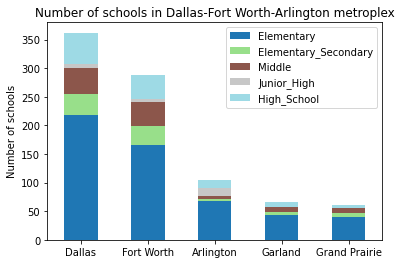

In [20]:
ax=Grade_level_classification.plot.bar(stacked=True,rot=0,colormap='tab20')
ax.set_xlabel(None)
ax.set_ylabel("Number of schools")
ax.set_title('Number of schools in Dallas-Fort Worth-Arlington metroplex')

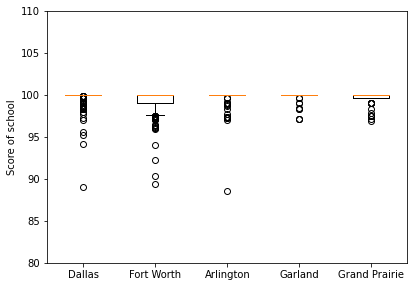

In [90]:
 
data_1 = Dallas.loc[Dallas['City']==labels[0]]['Score'].values 
data_2 = Dallas.loc[Dallas['City']==labels[1]]['Score'].values 
data_3 = Dallas.loc[Dallas['City']==labels[2]]['Score'].values
data_4 = Dallas.loc[Dallas['City']==labels[3]]['Score'].values
data_5 = Dallas.loc[Dallas['City']==labels[4]]['Score'].values
data = [data_1, data_2, data_3, data_4,data_5] 
  
fig = plt.figure(figsize =(5, 3.5)) 
  
# Creating axes instance 
ax = fig.add_axes([0, 0, 1, 1]) 
plt.ylim(80, 110)   
# Creating plot 
bp = ax.boxplot(data) 
ax.set_ylabel('Score of school')
ax.set_xticklabels(labels)
# show plot 
plt.show() 

##### There are 1342 schools in Dallas-Fort Worth-Arlington metropolitan area, and most of them located in Dallas, Fort Worth, Arlington, Garland, and Grand Prairie. The grade level distribution of five cities are shown. According to the boxplot of score, the average score of school in five cities are all close to 100. If we compare Dallas with Fort Worth, the lower 25% of school in Dallas achieves higher score. Based on the number of school and the average performance, we think that Dallas is a better city to live in the Dallas-Fort Worth-Arlington metroplex. 

3. Visualize the school location in city Dallas

In [25]:
# sort the schools in City Dallas based on score 
Dallas_school=Dallas[Dallas['City'].str.contains('Dallas')]
Dallas_school=Dallas_school[Dallas_school['Score']==100]
Dallas_school.head()

,School_Nam,Score,Match_addr,City,MetroArea,Subregion,X,Y,Grade_Leve,Grade_Number
779,PEGASUS CHARTER H S,100.0,"601 N Akard St, Dallas, Texas, 75201",Dallas,Dallas-Fort Worth Metroplex,Dallas County,-96.800821,32.784710,Elementary/Secondary,1.0
782,UPLIFT WILLIAMS PREPARATORY H S,100.0,"1750 Viceroy Dr, Dallas, Texas, 75235",Dallas,Dallas-Fort Worth Metroplex,Dallas County,-96.868821,32.836239,High School,4.0
783,UPLIFT LUNA PREPARATORY H S,100.0,"2625 Elm St, Dallas, Texas, 75226",Dallas,,Dallas County,-96.785348,32.784768,High School,4.0
784,UPLIFT HEIGHTS PREPARATORY H S,100.0,"2650 Canada Dr, Dallas, Texas, 75212",Dallas,Dallas-Fort Worth Metroplex,Dallas County,-96.865490,32.792599,High School,4.0
788,UPLIFT PEAK PREPARATORY H S,100.0,"4600 Bryan St, Bldg 2, Dallas, Texas, 75204",Dallas,,Dallas County,-96.775362,32.801130,High School,4.0


In [26]:
dallas_latitude=32.779167
dallas_longitude=-96.808891
map_dallas_school = folium.Map(location=[dallas_latitude, dallas_longitude], zoom_start=12)
for lat, lng, label, i in zip(Dallas_school['Y'], Dallas_school['X'], Dallas_school['School_Nam'],Dallas_school['Grade_Number']):
    label = folium.Popup(label, parse_html=True)
    colorseries=['blue','green','red','yellow','purple']
    folium.CircleMarker(
       [lat, lng],
        radius=3,
        popup=label,
        weight=1,
        stroke=False,
        color=colorseries[int(i)],
        fill=True,
        fill_color=colorseries[int(i)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_dallas_school)  
# add markers to map
#dallas_school = plugins.MarkerCluster().add_to(map_dallas_school)

# loop through the dataframe and add each data point to the mark cluster
#for lat, lng, label in zip(Dallas_school.Y, Dallas_school.X, Dallas_school['Score']):
   # folium.Marker(
   #     location=[lat, lng],
   #     icon=None,
   #     popup=label,
  #  ).add_to(dallas_school)

# display map
map_dallas_school    

### Compare the neighborhoods in Dallas

Dallas neighborhood information, such as its name, area, population, household income, and median home value is extracted from D Magazine (https://www.dmagazine.com/), a medium that covers a range of topics including politics, business, food, fashion and lifestyle in the city of Dallas. 

1. Neighborhood data acqusition and cleaning 

In [110]:
Dallas_neighborhood=pd.read_html('https://neighborhoods.dmagazine.com/')
Dallas_neighborhood=Dallas_neighborhood[0]
Dallas_neighborhood.head()


,Neighborhood,Population,Area (Square Miles),Pop. Density (Per Sq. Mile),Median Age,Age 18+,Household Income,Median Home Value,% Owner-Occupied,Avg. Commute in Minutes
0,Bent Tree,10215.0,2.59,3944.0,47.8,86.2%,"$79,127","$466,614",55.7%,23.0
1,Bluffview,4617.0,1.43,3228.7,38.9,75.0%,"$64,001","$624,068",61.9%,22.0
2,Casa Linda,4175.0,1.46,2859.6,46.3,80.8%,"$85,488","$234,502",83.3%,29.0
3,Central Dallas,148318.0,28.70,5167.9,34.4,83.4%,"$53,983","$247,887",25.5%,24.0
4,Deep Ellum - Expo Park,2621.0,0.63,4160.3,34.0,87.9%,"$53,659","$275,131",6.3%,23.0


In [111]:
Dallas_neighborhood.dtypes

Neighborhood                    object
Population                     float64
Area (Square Miles)            float64
Pop. Density (Per Sq. Mile)    float64
Median Age                     float64
Age 18+                         object
Household Income                object
Median Home Value               object
% Owner-Occupied                object
Avg. Commute in Minutes        float64
dtype: object

In [112]:
# Data cleaning and converting the datatype from object to float
Dallas_neighborhood['Age 18+']=pd.to_numeric(Dallas_neighborhood['Age 18+'].str.strip('%'))
Dallas_neighborhood['% Owner-Occupied']=pd.to_numeric(Dallas_neighborhood['% Owner-Occupied'].str.strip('%'))
Dallas_neighborhood['Household Income']=pd.to_numeric(Dallas_neighborhood['Household Income'].str.strip('$').str.replace(',',''))
Dallas_neighborhood['Median Home Value']=pd.to_numeric(Dallas_neighborhood['Median Home Value'].str.strip('$').str.replace(',',''))


In [114]:
Dallas_neighborhood.shape

(57, 10)

In [115]:
Dallas_neighborhood.dropna(inplace=True)

### Geocode the neighborhoods with GPS location
The location (latitude and longitude) of each neighborhood is obtained using GeoPy. Out of 56, the location of 44 neighborhoods are found, and the neighborhoods with location not found are ignored from further analysis. 

In [116]:
import numpy as np
latlog=pd.DataFrame(dtype=int,columns={'latitude','longitude'})
latlog.head()

,latitude,longitude


In [117]:
latlog.dtypes

latitude     int32
longitude    int32
dtype: object

In [118]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='maggi') 


In [119]:
#initiate a dataframe storing lat and log
latlog=pd.DataFrame(columns={'latitude','longitude'})

for row in Dallas_neighborhood.itertuples():
    #print(row[1])
    latlog.at[row,'Neighborhood']=row[1]
    try:
        location=geolocator.geocode('{}, Dallas, Texas'.format(row[1]))
        print((location.latitude, location.longitude))
        latlog.at[row,'latitude']=location.latitude
        latlog.at[row,'longitude']=location.longitude
    except: 
        print('No result returned for this location')
        latlog.at[row,'latitude']=pd.NA
        latlog.at[row,'longitude']=pd.NA

(32.9734109, -96.82630605603083)
(32.9764019, -96.90840146928147)
(32.8328657, -96.7001914)
(32.7762719, -96.7968559)
No result returned for this location
(32.7899087, -96.818811)
(32.9499313, -96.7392325)
(32.78015365, -96.79907350429801)
(32.7857009, -96.7964041)
(32.83565, -96.682605)
(32.936449, -96.77365)
(32.910592550000004, -96.72634058290672)
No result returned for this location
(32.831563, -96.80077329849314)
(32.8538778, -96.73167095968311)
No result returned for this location
(32.703787, -96.862141)
(32.886265, -96.7305964)
No result returned for this location
(32.8271318, -96.7524914)
No result returned for this location
(32.910592550000004, -96.72634058290672)
(32.8564971, -96.692144)
(32.8450229, -96.8498413)
(32.8146164, -96.7701728)
No result returned for this location
(32.80947825, -96.83754657660697)
(32.8713922, -96.8473384656408)
No result returned for this location
(32.7807807, -96.8044259)
(32.7392973, -96.8111126)
(32.903451450000006, -96.84827813648296)
(32.7762

In [120]:
latlog.reset_index(inplace=True,drop=True)
latlog

,latitude,longitude,Neighborhood
0,32.9734,-96.8263,Bent Tree
1,32.9764,-96.9084,Bluffview
2,32.8329,-96.7002,Casa Linda
3,32.7763,-96.7969,Central Dallas
4,<NA>,<NA>,Deep Ellum - Expo Park
5,32.7899,-96.8188,Design District
6,32.9499,-96.7392,Devonshire
7,32.7802,-96.7991,Downtown
8,32.7857,-96.7964,East Dallas
9,32.8357,-96.6826,Eastwood


In [121]:
Dallas_neighborhood['Latitude']=latlog['latitude']
Dallas_neighborhood['Longitude']=latlog['longitude']
#Dallas_neighborhood.Longitude=latlog.longitude

In [122]:
Dallas_neighborhood.head()
#Dallas_neighborhood.dtypes

,Neighborhood,Population,Area (Square Miles),Pop. Density (Per Sq. Mile),Median Age,Age 18+,Household Income,Median Home Value,% Owner-Occupied,Avg. Commute in Minutes,Latitude,Longitude
0,Bent Tree,10215.0,2.59,3944.0,47.8,86.2,79127.0,466614.0,55.7,23.0,32.9734,-96.8263
1,Bluffview,4617.0,1.43,3228.7,38.9,75.0,64001.0,624068.0,61.9,22.0,32.9764,-96.9084
2,Casa Linda,4175.0,1.46,2859.6,46.3,80.8,85488.0,234502.0,83.3,29.0,32.8329,-96.7002
3,Central Dallas,148318.0,28.70,5167.9,34.4,83.4,53983.0,247887.0,25.5,24.0,32.7763,-96.7969
4,Deep Ellum - Expo Park,2621.0,0.63,4160.3,34.0,87.9,53659.0,275131.0,6.3,23.0,<NA>,<NA>


In [123]:
#drop the entries with location not found
Dallas_neighborhood.dropna(inplace=True)

In [124]:
Dallas_neighborhood['Longitude']=Dallas_neighborhood['Longitude'].astype(float)
Dallas_neighborhood['Latitude']=Dallas_neighborhood['Latitude'].astype(float)

In [126]:
Dallas_neighborhood.shape

(44, 12)

In [127]:
Dallas_neighborhood.head()

,Neighborhood,Population,Area (Square Miles),Pop. Density (Per Sq. Mile),Median Age,Age 18+,Household Income,Median Home Value,% Owner-Occupied,Avg. Commute in Minutes,Latitude,Longitude
0,Bent Tree,10215.0,2.59,3944.0,47.8,86.2,79127.0,466614.0,55.7,23.0,32.973411,-96.826306
1,Bluffview,4617.0,1.43,3228.7,38.9,75.0,64001.0,624068.0,61.9,22.0,32.976402,-96.908401
2,Casa Linda,4175.0,1.46,2859.6,46.3,80.8,85488.0,234502.0,83.3,29.0,32.832866,-96.700191
3,Central Dallas,148318.0,28.70,5167.9,34.4,83.4,53983.0,247887.0,25.5,24.0,32.776272,-96.796856
5,Design District,1932.0,0.97,1985.6,33.2,96.5,80263.0,248000.0,2.0,20.0,32.789909,-96.818811


In [132]:
# visualize the neighborhoods location and area
dallas_latitude=32.779167
dallas_longitude=-96.808891
map_dallas_neighborhood = folium.Map(location=[dallas_latitude, dallas_longitude], zoom_start=10)
for lat, lng, area,label in zip(Dallas_neighborhood['Latitude'], Dallas_neighborhood['Longitude'], Dallas_neighborhood['Area (Square Miles)'],Dallas_neighborhood['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
       [lat, lng],
        radius=area*5 if area<10 else area,
        popup=label,
        weight=1,
        stroke=True,
        fill=True,
        fill_opacity=0.1,
        parse_html=False).add_to(map_dallas_school)  
map_dallas_school

### KMeans analysis to find the similarity between neighborhoods and visualize their location on the map
We run k-means clustering analysis to further explore neighborhoods that share common features. Performing the analysis with cluster number equal to 3 on the neighborhood dataframe, we found that six neighborhoods located in North Dallas could be assigned to the same cluster, as labeled in blue. The six neighborhoods are Highland Park, University Park, Preston Hollow, Devonshire, Preston Trail and Bluffview, which are those top household income and median home value according to the list. West Dallas, Love Field, Medical District, Northwest Dallas, Oak Cliff, Case View, Liestwood, Pleasant Grove and Ease Dallas could be assigned to the same cluster, as labeled in red, which are listed at the bottom part considering their household income or home value.   

In [128]:
# set number of clusters
kclusters = 3

Dallas_neighborhood_clustering=Dallas_neighborhood.drop(['Neighborhood','Latitude','Longitude'], 1)
Dallas_neighborhood_clustering.head()
# run k-means clustering
kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(Dallas_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans2.labels_#[0:50] 

array([0, 1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 2])

In [129]:
dallas_latitude=32.779167
dallas_longitude=-96.808891
map_dallas_neighborhood_cluster2 = folium.Map(location=[dallas_latitude, dallas_longitude], zoom_start=10)
colormap=['purple','blue','red','orange']
for lat, lng, color,label in zip(Dallas_neighborhood['Latitude'], Dallas_neighborhood['Longitude'], kmeans2.labels_,Dallas_neighborhood['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=6,
        color=colormap[color],
        stroke=False,
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_dallas_neighborhood_cluster2)  
map_dallas_neighborhood_cluster2

### Explore neighborhoods by household income and house values

One way to compare neighborhoods is based on the household income or house values. Therefore, we choose to plot them using bar plot in descending order

(-0.5, 44.0)

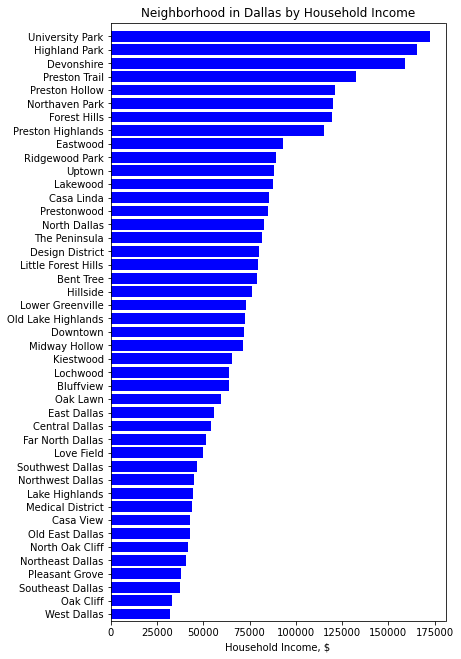

In [130]:
Dallas_neighborhood_income=Dallas_neighborhood.sort_values(by='Household Income',ascending=True)
ax1=plt.figure(figsize=(6,11))
ax1=plt.barh(Dallas_neighborhood_income['Neighborhood'],Dallas_neighborhood_income['Household Income'],color='blue')
plt.xlabel('Household Income, $')
plt.title('Neighborhood in Dallas by Household Income')
plt.ylim(-0.5,44)

(-0.5, 44.0)

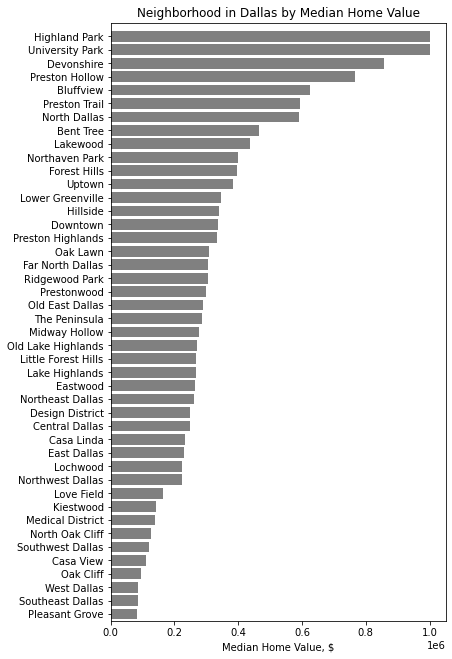

In [131]:
Dallas_neighborhood_value=Dallas_neighborhood.sort_values(by='Median Home Value',ascending=True)
ax1=plt.figure(figsize=(6,11))
ax1=plt.barh(Dallas_neighborhood_value['Neighborhood'],Dallas_neighborhood_value['Median Home Value'],color='grey')
plt.xlabel('Median Home Value, $')
plt.title('Neighborhood in Dallas by Median Home Value')
plt.ylim(-0.5,44)

## Explore neighborhoods by venues and venue category
Lastly, we explored the venues that are within 1000 meters radius from the neighborhood. The venue and venue categories that the most commonly appears will help us better understand the lifestyle of certain neighborhood, as well as the convinence of life.  
1. Make call of API 

In [133]:
# make call of API to search for neighborhood 
CLIENT_ID = '4IQGVSEUWJLC0EWSCIJRNGGOHHUMRDKSWCJOJ3XBWR1B4AJZ' # your Foursquare ID
CLIENT_SECRET = 'L3MBURCW2ZIFG53SXT0PTAJY3L2GQKY3DUEMA45OGEG122IN' # your Foursquare Secret
VERSION = '20210205' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

# create URL
limit=50
radius=1000 


Your credentails:
CLIENT_ID: 4IQGVSEUWJLC0EWSCIJRNGGOHHUMRDKSWCJOJ3XBWR1B4AJZ
CLIENT_SECRET:L3MBURCW2ZIFG53SXT0PTAJY3L2GQKY3DUEMA45OGEG122IN


In [50]:
#get venues of different neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [134]:
# make request to neighborhood 
neighbor_venues = getNearbyVenues(names=Dallas_neighborhood['Neighborhood'],
                                   latitudes=Dallas_neighborhood['Latitude'],
                                   longitudes=Dallas_neighborhood['Longitude']
                                  )

Bent Tree
Bluffview
Casa Linda
Central Dallas
Design District
Devonshire
Downtown
East Dallas
Eastwood
Far North Dallas
Forest Hills
Highland Park
Hillside
Kiestwood
Lake Highlands
Lakewood
Little Forest Hills
Lochwood
Love Field
Lower Greenville
Medical District
Midway Hollow
North Dallas
North Oak Cliff
Northaven Park
Northeast Dallas
Northwest Dallas
Oak Cliff
Oak Lawn
Old East Dallas
Old Lake Highlands
Pleasant Grove
Preston Highlands
Preston Hollow
Preston Trail
Prestonwood
Ridgewood Park
Southeast Dallas
Southwest Dallas
The Peninsula
University Park
Uptown
West Dallas
Casa View


In [136]:
neighbor_venues.shape
#neighbor_venues.head()

(2079, 7)

2079 venus are returned in total

### Compare the number of venues in each neighborhood
Based on the results that is returned from Foursquare APT, neighborhoods that located in urban area of Dallas returns the most venues and venue categories, including Downtown Dallas, East Dallas, Old Lawn, etc. The most frequent venue categories are hotel, restaurant, coffee shop, and bar. 
It is followed by Casa Linda, Devonshire, and Old East Dallas, which locate at Northeast Dallas. The most frequent venue categories are restaurant, coffee shop, gym, and fast-food restaurant.
University Park, Highland Park, Bluffview, and Preston Trail has around 50 different venues, with salon, gym, park, and restaurant being most common venue categories.


(-0.5, 44.0)

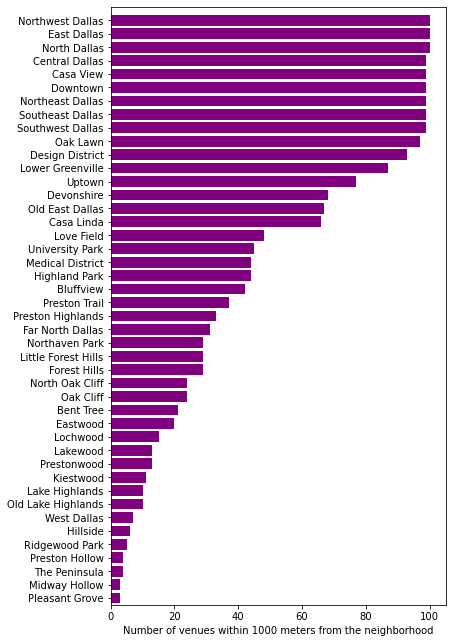

In [83]:

Dallas_neighborhood_venue=neighbor_venues.groupby('Neighborhood').nunique().sort_values(by='Venue')
ax2=plt.figure(figsize=(6,11))
ax2=plt.barh(Dallas_neighborhood_venue.index,Dallas_neighborhood_venue['Venue'],color='Purple')
plt.xlabel('Number of venues within 1000 meters from the neighborhood')
plt.ylim(-0.5,44)

(-0.5, 44.0)

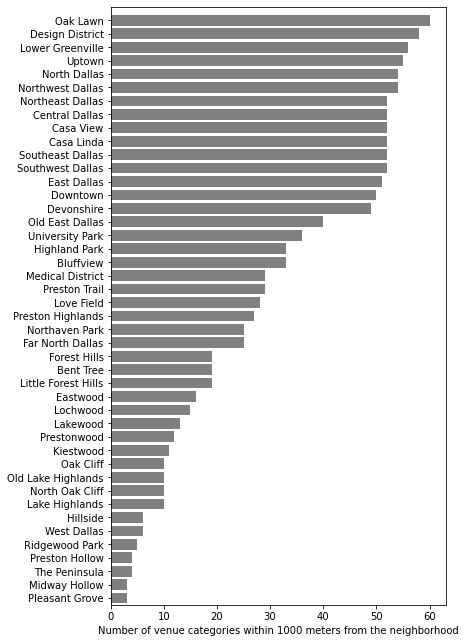

In [86]:
Dallas_neighborhood_category=neighbor_venues.groupby('Neighborhood').nunique().sort_values(by='Venue Category')
ax2=plt.figure(figsize=(6,11))
ax2=plt.barh(Dallas_neighborhood_category.index,Dallas_neighborhood_category['Venue Category'],color='Grey')
plt.xlabel('Number of venue categories within 1000 meters from the neighborhood')
plt.ylim(-0.5,44)

In [54]:
# one hot encoding
Dallas_onehot = pd.get_dummies(neighbor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Dallas_onehot['Neighborhood'] = neighbor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Dallas_onehot.columns[-1]] + list(Dallas_onehot.columns[:-1])
Dallas_onehot = Dallas_onehot[fixed_columns]

Dallas_onehot.head()

,Neighborhood,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorsports Shop,Movie Theater,Multiplex,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bent Tree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Bent Tree,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [55]:
#list of venues grouped by neighborhood
Dallas_grouped = Dallas_onehot.groupby('Neighborhood').mean().reset_index()
Dallas_grouped

,Neighborhood,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,Airport,Airport Food Court,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bistro,Bookstore,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Flea Market,Flower Shop,Food,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motorsports Shop,Movie Theater,Multiplex,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Pool,Print Shop,Pub,Ramen Restaurant,Recreation Center,Rental Car Location,Restaurant,Road,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterans' Organization,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Bent Tree,0.000000,0.000000,0.000000,0.00000,0.047619,0.000000,0.000000,0.047619,0.047619,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.00,0.047619,0.000000,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.00000

In [56]:
num_top_venues = 5

for hood in Dallas_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Dallas_grouped[Dallas_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bent Tree----
          venue  freq
0           Spa  0.14
1       Dog Run  0.05
2    Food Truck  0.05
3    Nail Salon  0.05
4  Burger Joint  0.05


----Bluffview----
                 venue  freq
0    Indian Restaurant  0.07
1       Ice Cream Shop  0.05
2     Sushi Restaurant  0.05
3  Fried Chicken Joint  0.05
4      Bubble Tea Shop  0.05


----Casa Linda----
                  venue  freq
0  Fast Food Restaurant  0.05
1                   Gym  0.03
2        Sandwich Place  0.03
3                  Bank  0.03
4    Chinese Restaurant  0.03


----Casa View----
          venue  freq
0         Hotel  0.14
1   Coffee Shop  0.08
2           Bar  0.06
3           Gym  0.04
4  Cocktail Bar  0.04


----Central Dallas----
          venue  freq
0         Hotel  0.14
1   Coffee Shop  0.08
2           Bar  0.06
3           Gym  0.04
4  Cocktail Bar  0.04


----Design District----
                  venue  freq
0           Art Gallery  0.05
1            Sports Bar  0.04
2  Gym / Fitness Center  0.04


In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Dallas_grouped['Neighborhood']

for ind in np.arange(Dallas_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dallas_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bent Tree,Spa,Italian Restaurant,Deli / Bodega,Coffee Shop,Dog Run
1,Bluffview,Indian Restaurant,Ice Cream Shop,Fast Food Restaurant,Fried Chicken Joint,Sushi Restaurant
2,Casa Linda,Fast Food Restaurant,Pharmacy,Bank,Sandwich Place,Food
3,Casa View,Hotel,Coffee Shop,Bar,Gym,Cocktail Bar
4,Central Dallas,Hotel,Coffee Shop,Bar,Gym,Cocktail Bar
5,Design District,Art Gallery,Gym / Fitness Center,Sports Bar,New American Restaurant,Mexican Restaurant
6,Devonshire,Bar,Indian Restaurant,Burger Joint,Bakery,Dessert Shop
7,Downtown,Hotel,Coffee Shop,Cocktail Bar,Steakhouse,Mexican Restaurant
8,East Dallas,Hotel,Coffee Shop,Mexican Restaurant,Steakhouse,Food Truck
9,Eastwood,Pizza Place,Mexican Restaurant,Gas Station,Cosmetics Shop,Discount Store


## Conclusion
Dallas will be a good optionto relocate for stakeholders who are planning to move to Dallas-Fort Worth-Arlington metroplex  and consider the school districts an important factors, since it has the most schools in Dallas-Fort Worth-Arlington metroplex with all range of grades and above average school score. Our preliminary data suggests that Dallas neighborhoods can be classified into following categories: 
1.	Upper-class neighborhoods located in the suburb northern Dallas. The nearest school district is Highland Park ISD, ranked third in DFW school districts. Examples: **University Park, Highland Park, Devonshire**. We recommend these neighborhoods to wealthy stakeholders who are looking for high-end, modern country style neighborhood and top schools.
2.	Middle class neighborhoods located in the suburb Dallas. The neighborhoods have moderate numbers of local business including restaurant, gym, and solon. Examples: **Preston Trail, Preston Hollow, Preston Highlands, Northaven Park, Forest Hill**. We would recommend these neighborhoods to middle class. 
3.	Urban neighborhoods featuring a modern lifestyle. Many schools around. Examples: **Downtown Dallas, East Dallas, Uptown, Design District**. We would recommend these neighborhoods to younger generations who enjor urban and night life. 

